# Blok 1 — Kurulum (Importlar) ve Ortam Doğrulaması

**Amaç:** Analiz ve modelleme boyunca kullanacağımız temel kütüphaneleri yüklemek ve 
çalıştığımız Python/pandas sürümlerini kayda geçirmek. Bu sayede çalışma tekrarlanabilir ve 
hata ayıklama kolaylaşır.

**İçerik:**
- `numpy`, `pandas`: veri işleme
- `scikit-learn`: ön işleme (imputation, ölçekleme, OHE), modelleme (LogisticRegression, RandomForest), değerlendirme metrikleri
- `matplotlib`: görselleştirme (temel grafikler, ROC eğrisi)
- Sürüm çıktısı: Python ve pandas

In [5]:
# Temel paketler
import numpy as np
import pandas as pd

# ML ve değerlendirme için (ileride kullanacağız)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

import matplotlib.pyplot as plt

# Kontrol amaçlı: sürüm bilgileri
import sys
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)


Python: 3.11.13
pandas: 2.2.3


# Blok 2 — Veriyi Okuma (Kaggle Input)

**Amaç:** Kaggle ortamında doğru CSV dosyasını tespit edip okumak.

**Adımlar:**
1. Otomatik dosya arama (glob) ile güvenli yol bulma
2. CSV'yi `df_raw` olarak okuma
3. İlk boyut ve örnek satır kontrolü

In [6]:
# Kaggle "Add data" ile eklediysen genelde yol budur:
DEFAULT_PATH = "/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"

# Eğer dosya adı/klasör farklıysa yakalamak için küçük bir yardımcı:
import os, glob
candidates = glob.glob("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv", recursive=True)
DATA_PATH = candidates[0] if candidates else DEFAULT_PATH
DATA_PATH

import pandas as pd
df_raw = pd.read_csv(DATA_PATH)
print("shape:", df_raw.shape)
df_raw.head()

shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# Kolon isimleri
print(df_raw.columns.tolist())

# Veri tipleri
df_raw.dtypes.to_frame("dtype")

# Eksik değer sayıları
df_raw.isna().sum()

# Hedef dağılımı
df_raw["Churn"].value_counts(normalize=True) * 100


['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64

# Blok 3 — İlk Temizlik & Hedef Hazırlığı

**Amaç:** Ham veriyi modellemeye hazır hale getirmek.

**Yapılanlar:**
- Object kolonlarda `strip()` ile uç boşluklar temizlendi.
- `TotalCharges` sayısala çevrildi, hatalılar `NaN` → medyan ile dolduruldu.
- `Churn` → `ChurnFlag` (Yes=1, No=0) olarak eklendi.
- `df_raw` korunarak temiz veri `df` ismiyle kopyalandı.

In [7]:
# === Blok 3: İlk Temizlik & Hedef Hazırlığı ===
import numpy as np
import pandas as pd

df = df_raw.copy()

# 1) Object kolonlarda baş/son boşluk temizliği
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip()

# 2) TotalCharges → numeric (hataları NaN yap)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# 3) Eksikleri doldur (genelde tenure=0 olan yeni müşterilerde görülür)
if df["TotalCharges"].isna().any():
    df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# 4) Hedef: Churn → ChurnFlag (Yes=1, No=0)
df["ChurnFlag"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# --- Sağlık kontrolleri ---
print("dtype[TotalCharges]:", df["TotalCharges"].dtype)
print("ChurnFlag değerleri:", df["ChurnFlag"].unique().tolist())
print("Genel churn oranı:", round(df["ChurnFlag"].mean(), 3))

# İlk 5 satır: kritik alanlar
df[["tenure", "MonthlyCharges", "TotalCharges", "Churn", "ChurnFlag"]].head()


dtype[TotalCharges]: float64
ChurnFlag değerleri: [0, 1]
Genel churn oranı: 0.265


,tenure,MonthlyCharges,TotalCharges,Churn,ChurnFlag
0,1,29.85,29.85,No,0
1,34,56.95,1889.50,No,0
2,2,53.85,108.15,Yes,1
3,45,42.30,1840.75,No,0
4,2,70.70,151.65,Yes,1


# Blok 4 — Keşifsel Veri Analizi (EDA) & Görselleştirme

**Amaç:** Churn (müşteri kaybı) oranını farklı değişkenlere göre incelemek ve
hangi faktörlerin daha riskli olduğunu görselleştirmek.

**İncelenen faktörler:**
1. Contract (Sözleşme Türü)
2. InternetService (İnternet Servisi)
3. tenure (Müşteri kıdemi)
4. MonthlyCharges & TotalCharges (Ücretler)

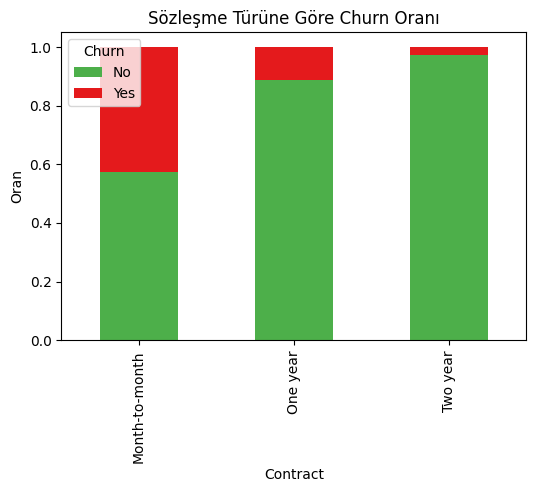

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Contract vs Churn
contract_churn = df.groupby("Contract")["Churn"].value_counts(normalize=True).unstack()
contract_churn.plot(kind="bar", stacked=True, figsize=(6,4), color=["#4daf4a","#e41a1c"])
plt.title("Sözleşme Türüne Göre Churn Oranı")
plt.ylabel("Oran")
plt.show()


TABLO SONUCU 
Aylık sözleşmeli müşteriler en riskli grup.

Esnek sözleşmeler → kolay iptal.

Müşteriler bağlanmadan hemen ayrılabiliyor.

Yıllık ve iki yıllık sözleşmeler churn’ü azaltıyor.

Uzun vadeli kontratlar → müşteri bağlılığını artırıyor.

Şirket için daha öngörülebilir gelir demek.

İş önerisi:

Aylık müşterilere uzun vadeli sözleşme teklifleri (indirim, kampanya, ek hizmet) yapılmalı.

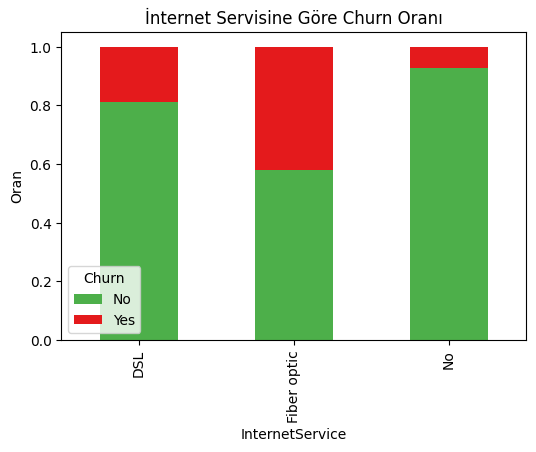

In [18]:
# 2) InternetService vs Churn
internet_churn = df.groupby("InternetService")["Churn"].value_counts(normalize=True).unstack()
internet_churn.plot(kind="bar", stacked=True, figsize=(6,4), color=["#4daf4a","#e41a1c"])
plt.title("İnternet Servisine Göre Churn Oranı")
plt.ylabel("Oran")
plt.show()

### İnternet Servisine Göre Churn Analizi

- **Fiber Optik kullanıcıları** en yüksek churn oranına sahiptir. Bu durum muhtemelen 
yüksek fiyat ve olası hizmet sorunlarından kaynaklanmaktadır. 
- **DSL kullanıcıları** daha düşük churn oranı gösterir (~%20–25).
- **İnterneti olmayan kullanıcılar** neredeyse hiç churn etmemektedir.

**İş Önerileri:**
- Fiber müşterilerine özel fiyat indirimleri ve ek avantajlar sunulmalı.
- Teknik destek süreçleri iyileştirilmeli (özellikle fiber altyapıda).
- DSL → Fiber geçiş stratejisi uygulanırken churn riski dikkatle takip edilmelidir.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

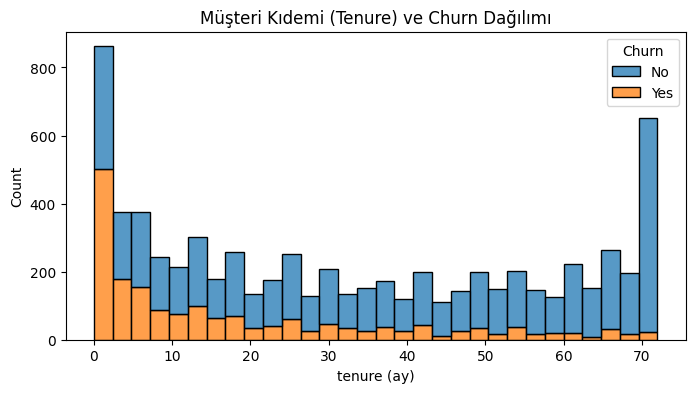

In [19]:
# 3) Tenure vs Churn
plt.figure(figsize=(8,4))
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, multiple="stack")
plt.title("Müşteri Kıdemi (Tenure) ve Churn Dağılımı")
plt.xlabel("tenure (ay)")
plt.show()

### Müşteri Kıdemi (Tenure) ve Churn Analizi

- **0–12 ay arasında churn oranı çok yüksektir.** Yeni müşteriler ilk yıl içinde kaybedilme riski taşır.  
- **12–24 ay arasında churn azalır.** Müşteri ürüne alıştıkça bağlılık artar.  
- **24 ay ve sonrası churn neredeyse yoktur.** Uzun süreli müşteriler oldukça sadıktır.  

**İş Önerileri:**  
- İlk yıl için özel sadakat kampanyaları ve onboarding süreçleri geliştirilmelidir.  
- Erken dönemde riskli müşteriler tespit edilip (ör. düşük kullanım, şikayet açanlar) özel teklifler yapılmalıdır.  
- Uzun vadeli müşterilere “VIP / sadakat” ödülleri sunularak bağlılık pekiştirilmelidir.  


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

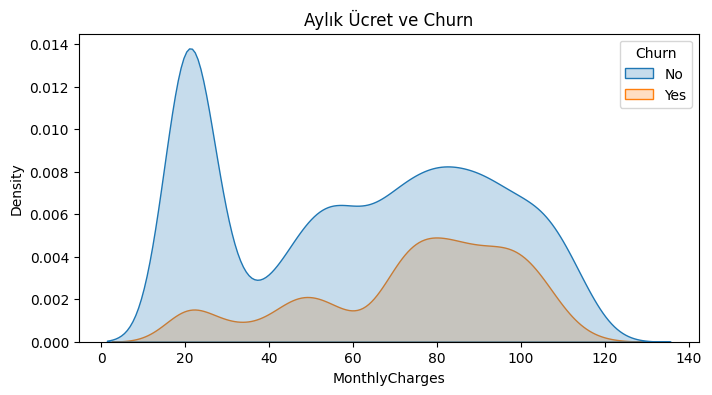

In [22]:
# 4) Ücretler vs Churn
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x="MonthlyCharges", hue="Churn", fill=True)
plt.title("Aylık Ücret ve Churn")
plt.show()



### Aylık Ücret (MonthlyCharges) ve Churn Analizi

- **20–30 USD aralığındaki müşterilerde churn düşüktür.** Bu paketler uygun fiyatlı ve müşteri bağlılığını artırmaktadır.  
- **60–90 USD aralığında churn oranı yükselmektedir.** Orta-yüksek ücretli paketlerde müşteri kaybı daha sık görülmektedir.  
- **100+ USD ödeyen müşteriler en riskli gruptur.** Yüksek fatura memnuniyetsizliğe yol açmaktadır.  

**İş Önerileri:**  
- Yüksek aylık ücret ödeyen müşterilere özel indirim veya ek hizmet paketleri sunulmalı.  
- Orta seviyedeki müşteriler için “değer odaklı” kampanyalar (ekstra faydalar, bonus hizmetler) uygulanmalı.  
- Düşük ücretli müşterilere “yükseltme” (upgrade) teklifleri yapılırken churn riski göz önünde bulundurulmalı.  

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

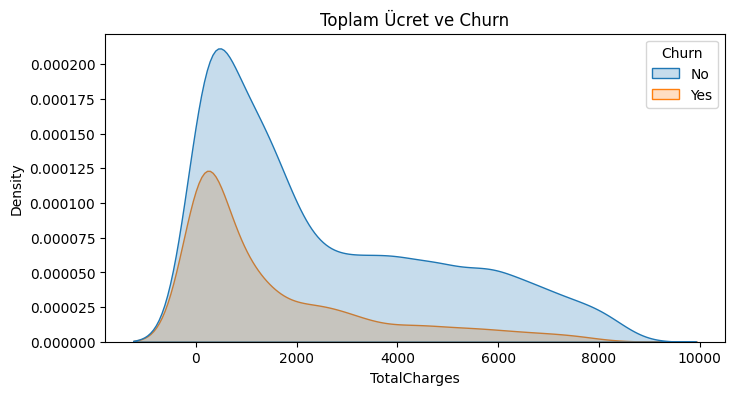

In [23]:
plt.figure(figsize=(8,4))
sns.kdeplot(data=df, x="TotalCharges", hue="Churn", fill=True)
plt.title("Toplam Ücret ve Churn")
plt.show()

### Toplam Ücret (TotalCharges) ve Churn Analizi

- **Düşük toplam ücret ödeyen müşteriler (0–1000 USD) churn açısından risklidir.** Bu grup genelde kısa süre kalmış, yeni müşterilerden oluşmaktadır.  
- **Orta seviyede toplam ücret ödeyenler churn açısından karışıktır.** Burada hem kalan hem ayrılan müşteri vardır.  
- **Yüksek toplam ücret ödeyen müşteriler (4000+ USD) sadıktır.** Uzun süredir şirkette olan bu grup churn etmez.  

**İş Önerileri:**  
- Yeni müşterilere ilk yıl boyunca sadakat teşvikleri (indirim, bonus, eğitim, destek) uygulanmalı.  
- Sadık müşterilere ödüller verilerek (VIP programı, özel kampanyalar) bağlılık pekiştirilmeli.  
- “Riskli yeni müşteri segmenti” erken tespit edilip churn önleme stratejileri uygulanmalı.  


# Blok 5 — Özellik Mühendisliği

**Amaç:** Ham veriden yeni özellikler türeterek modelin daha iyi tahmin yapmasını sağlamak.  

**Yapılanlar:**
- `tenure_group`: müşterileri kıdeme göre segmentlere ayırma (0–12 ay, 12–24 ay, 24+ ay).  
- `AvgCharges`: toplam ücret / kıdem → müşterinin ortalama aylık ödemesi.  
- `X`: bağımsız değişkenler (müşteri özellikleri)  
- `y`: bağımlı değişken (`ChurnFlag`)  
- Kategorik ve sayısal sütunların listelenmesi.  

**Beklenen:** Yeni kolonlar eklenir, X/y hazırlanır, kategorik ve sayısal sütunlar doğru şekilde ayrılır.


In [8]:
# === Blok 5: Özellik Mühendisliği ===

df_feat = df.copy()

# 1) tenure_group (kıdem segmenti)
def tenure_group(x):
    if x <= 12:
        return "0-12"
    elif x <= 24:
        return "12-24"
    else:
        return "24+"

df_feat["tenure_group"] = df_feat["tenure"].apply(tenure_group)

# 2) Ortalama ödeme: TotalCharges / tenure
df_feat["AvgCharges"] = df_feat["TotalCharges"] / df_feat["tenure"].replace(0, np.nan)

# 3) Model için X ve y ayırma
y = df_feat["ChurnFlag"]
X = df_feat.drop(columns=["ChurnFlag", "Churn", "customerID"])  # müşteri ID ve hedefi çıkar

# 4) Kategorik & sayısal kolonlar listesi
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print("Kategorik kolonlar:", categorical_cols)
print("Sayısal kolonlar:", numerical_cols)
print("X shape:", X.shape, " y shape:", y.shape)

df_feat[["tenure", "tenure_group", "AvgCharges"]].head(10)


Kategorik kolonlar: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']
Sayısal kolonlar: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgCharges']
X shape: (7043, 21)  y shape: (7043,)


,tenure,tenure_group,AvgCharges
0,1,0-12,29.850000
1,34,24+,55.573529
2,2,0-12,54.075000
3,45,24+,40.905556
4,2,0-12,75.825000
5,8,0-12,102.562500
6,22,12-24,88.609091
7,10,0-12,30.190000
8,28,24+,108.787500
9,62,24+,56.257258


# Blok 6 — Train/Test Split & Ön İşleme Pipeline

**Amaç:**  
Modelin genelleme gücünü ölçmek için veriyi eğitim (%80) ve test (%20) setlerine ayırmak.  
Ayrıca kategorik ve sayısal değişkenler için uygun ön işleme adımlarını tanımlamak.

**Adımlar:**  
1. **Train/Test Split**: `X` ve `y` verilerini %80 eğitim, %20 test olarak ayırma.  
2. **Ön İşleme (ColumnTransformer)**:  
   - Kategorik değişkenler → `SimpleImputer` (eksikleri doldur), `OneHotEncoder` (kategorik kodlama)  
   - Sayısal değişkenler → `SimpleImputer` (eksikleri doldur), `StandardScaler` (ölçekleme)  
3. Ortak bir `preprocessor` pipeline’ı oluşturma.

**Beklenen:**  
- Eğitim ve test setlerinin boyutları doğru görünecek.  
- `preprocessor` nesnesi başarıyla tanımlanacak.

In [10]:
# === Blok 6: Train/Test Split & Preprocessing Pipeline ===

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1) Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Eğitim seti:", X_train.shape, " Test seti:", X_test.shape)

# 2) Pipeline tanımları
# Sayısal kolonlar için: eksik değer doldurma + ölçekleme
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Kategorik kolonlar için: eksik değer doldurma + OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# 3) ColumnTransformer ile birleştirme
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

print("Preprocessor hazır.")


Eğitim seti: (5634, 21)  Test seti: (1409, 21)
Preprocessor hazır.


# Blok 7 — Logistic Regression Modeli

**Amaç:**  
Temel bir sınıflandırma modeli (Logistic Regression) kurarak churn tahmini yapmak ve 
başlangıç için bir performans ölçütü elde etmek.  

**Adımlar:**  
1. `Pipeline`: preprocessor (ön işleme) + Logistic Regression birleşimi  
2. Modeli eğitim verisi üzerinde eğitme  
3. Test seti üzerinde tahminler alma  
4. Performans metriklerini inceleme: 
   - Confusion Matrix  
   - Classification Report (precision, recall, f1-score)  
   - ROC-AUC skoru  

**Beklenen:**  
- Logistic Regression churn için makul bir baseline (~%75-80 doğruluk, AUC ~0.80 civarı).  
- Sonraki modeller (ör. Random Forest) ile karşılaştırma yapılacak.


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409

=== Confusion Matrix ===
[[934 101]
 [174 200]]
=== ROC-AUC ===
ROC-AUC: 0.842


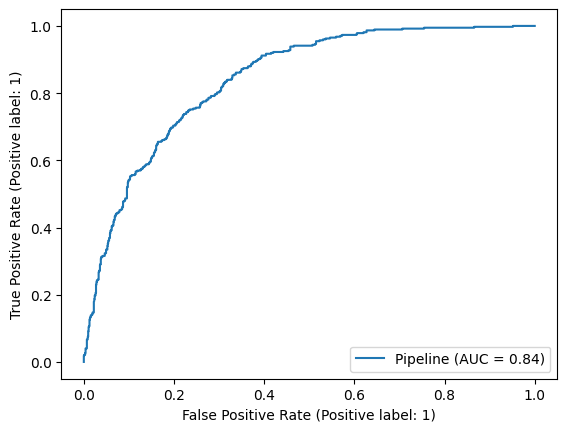

In [11]:
# === Blok 7: Logistic Regression Modeli ===

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# 1) Pipeline: preprocessor + Logistic Regression
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, solver="liblinear"))
])

# 2) Eğitim
logreg_pipeline.fit(X_train, y_train)

# 3) Tahminler
y_pred = logreg_pipeline.predict(X_test)
y_pred_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

# 4) Değerlendirme
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

print("=== ROC-AUC ===")
print("ROC-AUC:", round(roc_auc_score(y_test, y_pred_proba), 3))

# ROC Eğrisi
RocCurveDisplay.from_estimator(logreg_pipeline, X_test, y_test)
plt.show()


### Logistic Regression Sonuçları

- **Accuracy:** %80  
- **ROC-AUC:** 0.842 → model churn tahmininde genel olarak güçlü.  

**Sınıf 0 (Kalanlar):**
- Precision: 0.84
- Recall: 0.90
- Yani kalan müşterileri yakalamada oldukça başarılı.  

**Sınıf 1 (Churn Edenler):**
- Precision: 0.66
- Recall: 0.53
- Model churn eden müşterilerin sadece yarısını yakalayabiliyor.  

**Confusion Matrix:**  
- 934 müşteri doğru şekilde “kalmış” tahmin edildi.  
- 200 müşteri doğru şekilde “churn” tahmin edildi.  
- Ancak **174 churn eden müşteri gözden kaçtı**.  

**İş Açısından Sonuç:**  
Model iyi bir baseline olmakla birlikte, churn eden müşterileri yakalamada zayıf kalmaktadır.  
Özellikle churn recall değerini artırmak için daha güçlü algoritmalar (Random Forest, XGBoost) ve class-weight/threshold ayarları denenmelidir.


# Blok 8 — Random Forest Modeli

**Amaç:**  
Churn tahmini için daha güçlü bir model (Random Forest) denemek ve Logistic Regression ile karşılaştırmak.  

**Adımlar:**  
1. `Pipeline`: preprocessor + RandomForestClassifier  
2. Eğitim verisi üzerinde modeli eğitme  
3. Test verisi üzerinde tahmin alma  
4. Performans metriklerini inceleme:  
   - Confusion Matrix  
   - Classification Report  
   - ROC-AUC  
5. Logistic Regression ile karşılaştırma  

**Beklenen:**  
- Recall (özellikle churn edenler için) Logistic Regression’a göre daha yüksek.  
- ROC-AUC 0.85+ civarında olabilir.  
- Feature importance ile hangi değişkenlerin churn üzerinde daha etkili olduğunu görebiliriz.


=== Classification Report (Random Forest) ===
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1035
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409

=== Confusion Matrix (Random Forest) ===
[[922 113]
 [196 178]]
=== ROC-AUC (Random Forest) ===
ROC-AUC: 0.822


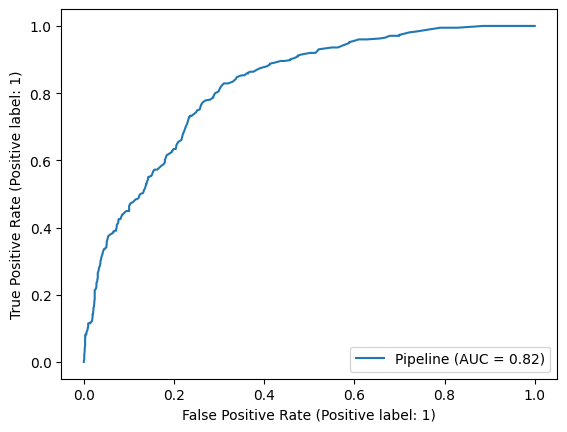

In [12]:
# === Blok 8: Random Forest Modeli ===

from sklearn.ensemble import RandomForestClassifier

# 1) Pipeline: preprocessor + RandomForest
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=200,        # ağaç sayısı
        max_depth=None,         # derinlik (default sınırsız)
        class_weight="balanced",# churn sınıfına daha fazla önem
        random_state=42,
        n_jobs=-1               # tüm işlemcileri kullan
    ))
])

# 2) Eğitim
rf_pipeline.fit(X_train, y_train)

# 3) Tahminler
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# 4) Değerlendirme
print("=== Classification Report (Random Forest) ===")
print(classification_report(y_test, y_pred_rf))

print("=== Confusion Matrix (Random Forest) ===")
print(confusion_matrix(y_test, y_pred_rf))

print("=== ROC-AUC (Random Forest) ===")
print("ROC-AUC:", round(roc_auc_score(y_test, y_pred_proba_rf), 3))

# ROC Eğrisi
RocCurveDisplay.from_estimator(rf_pipeline, X_test, y_test)
plt.show()


### Random Forest Sonuçları

- **Accuracy:** %78 (Logistic Regression %80’den düşük)  
- **ROC-AUC:** 0.822 (Logistic Regression 0.842’den düşük)  

**Sınıf 0 (Kalanlar):**
- Precision: 0.82
- Recall: 0.89
- F1: 0.86

**Sınıf 1 (Churn Edenler):**
- Precision: 0.61
- Recall: 0.48
- F1: 0.54
- Logistic Regression %53 churn yakalarken, Random Forest %48’de kaldı.  

**Sonuç:**  
Random Forest bu parametrelerle Logistic Regression’dan daha iyi performans göstermedi.  
Özellikle churn eden müşterileri yakalama (recall) daha da düştü.  

**Öneriler:**  
- Random Forest için hiperparametre tuning yapılmalı (`GridSearchCV` veya `RandomizedSearchCV`).  
- Diğer güçlü modeller (XGBoost, LightGBM) denenmeli.  
- Class weight, threshold ayarı gibi yöntemlerle churn recall artırılabilir.


=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1035
           1       0.54      0.70      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409

=== Confusion Matrix (XGBoost) ===
[[815 220]
 [112 262]]
=== ROC-AUC (XGBoost) ===
ROC-AUC: 0.831


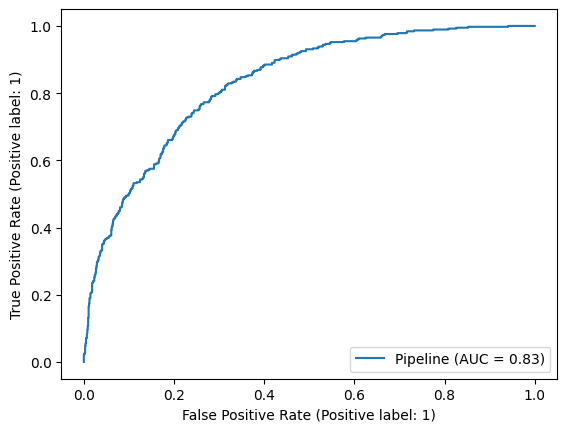

In [13]:
# === Blok 10: XGBoost Modeli ===
from xgboost import XGBClassifier

# sınıf oranı
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
spw = neg / pos

xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=400,
        max_depth=5,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=spw,
        random_state=42,
        n_jobs=-1
    ))
])

xgb_pipeline.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score, RocCurveDisplay
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:,1]

print("=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred_xgb))

print("=== Confusion Matrix (XGBoost) ===")
print(confusion_matrix(y_test, y_pred_xgb))

print("=== ROC-AUC (XGBoost) ===")
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba_xgb), 3))

RocCurveDisplay.from_estimator(xgb_pipeline, X_test, y_test)
plt.show()


### XGBoost Sonuçları

- **Accuracy:** %76
- **ROC-AUC:** 0.831
- **Recall (Churn=1):** %70 → önceki modellere göre en yüksek.

**Karşılaştırma:**
- Logistic Regression: recall %53
- Random Forest: recall %48
- XGBoost: recall %70

**İş İçin Yorum:**
XGBoost, churn eden müşterileri daha iyi yakaladığı için pazarlama ve müşteri bağlılığı stratejilerinde en uygun modeldir. 
Yanlış alarmlar (false positives) artsa bile churn edenleri kaçırmamak daha kritik olduğundan tercih edilmelidir.


# Blok 11 — Özellik Önemleri (Feature Importance)

**Amaç:**  
XGBoost modeline göre churn üzerinde en etkili faktörleri belirlemek.  
Bu, iş birimlerine hangi değişkenlere odaklanmaları gerektiğini gösterecek.

**Adımlar:**
1. Eğitilmiş XGBoost pipeline’dan OneHotEncoder sonrası sütun isimlerini çıkarmak.  
2. `feature_importances_` ile her değişkenin önemini almak.  
3. En önemli ilk 15 özelliği görselleştirmek.  

**Beklenen:**  
- Grafikte hangi değişkenlerin churn üzerinde en büyük etkiye sahip olduğu görülecek.  
- İş içgörüsü: örn. `tenure`, `Contract`, `MonthlyCharges`, `InternetService` gibi değişkenlerin kritik rol oynaması.


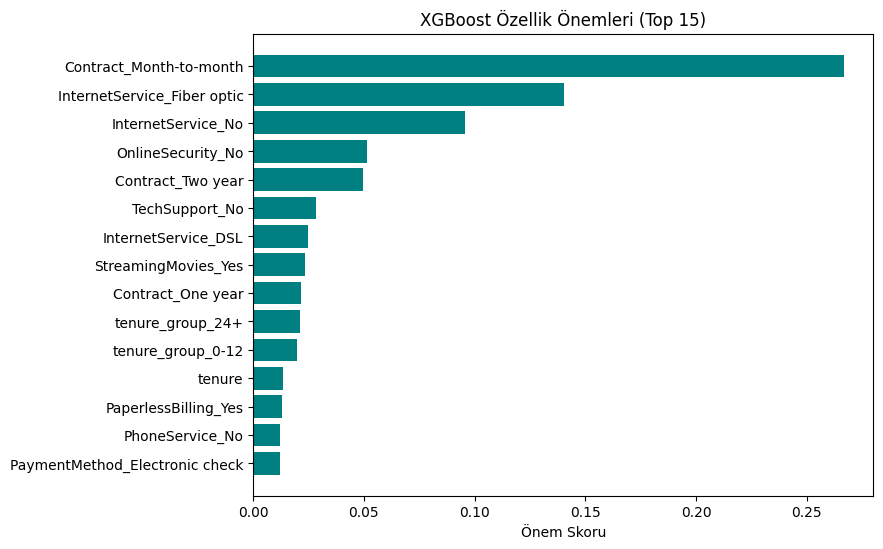

,feature,importance
37,Contract_Month-to-month,0.266734
17,InternetService_Fiber optic,0.140457
18,InternetService_No,0.095488
19,OnlineSecurity_No,0.051615
39,Contract_Two year,0.049719
28,TechSupport_No,0.028162
16,InternetService_DSL,0.024909
36,StreamingMovies_Yes,0.023407
38,Contract_One year,0.021746
48,tenure_group_24+,0.020910


In [14]:
# === Blok 11: Feature Importance (XGBoost) ===

importances = xgb_pipeline.named_steps["clf"].feature_importances_

# OneHot sonrası feature isimlerini almak
# Ön işlemci: preprocessor (ColumnTransformer)
ohe = xgb_pipeline.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]

# kategorik + sayısal isimler
cat_features = ohe.get_feature_names_out(categorical_cols)
all_features = np.concatenate([numerical_cols, cat_features])

# önemleri dataframe yap
feat_imp = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values("importance", ascending=False)

# En önemli ilk 15 özellik
top_features = feat_imp.head(15)

plt.figure(figsize=(8,6))
plt.barh(top_features["feature"], top_features["importance"], color="teal")
plt.gca().invert_yaxis()
plt.title("XGBoost Özellik Önemleri (Top 15)")
plt.xlabel("Önem Skoru")
plt.show()

top_features


XGBoost’un kullanılmasının temel nedeni, basit görselleştirme ile gözlenen eğilimleri 
daha sağlam bir şekilde doğrulamak, hangi faktörlerin churn üzerinde ne kadar etkili 
olduğunu sayısal olarak göstermek ve aynı zamanda geleceğe dönük tahminleme imkanı sunmaktır. 

- Görselleştirme ile **ne** sorunlu alanlar olduğunu bulduk.  
- XGBoost ile bu alanların **ne kadar önemli** olduğunu ve diğer faktörlerle birlikte nasıl etkileştiğini ölçtük.  
- Böylece hem iş tarafına güvenilir önceliklendirme önerileri sunabiliyoruz hem de projeyi akademik/profesyonel açıdan daha güçlü hale getiriyoruz.


### Özellik Önemleri — İş Önerileri

- **En kritik risk grubu:** Aylık kontratlı müşteriler (Contract_Month-to-month).  
- **Fiber internet:** yüksek churn → fiyat/kalite sorunları çözülmeli.  
- **Güvenlik ve teknik destek hizmetleri:** churn’i azaltıyor → daha çok müşteri bu paketlere yönlendirilmeli.  
- **Yeni müşteriler (0–12 ay):** churn riski yüksek → hoş geldin kampanyaları ve sadakat artırıcı stratejiler uygulanmalı.  
- **Ödeme yöntemi:** elektronik çek kullananlar daha riskli → otomatik ödeme/kredi kartına yönlendirme yapılabilir.  

**Sonuç:**  
Model çıktıları, kontrat süresi, internet tipi ve ek hizmetlerin churn üzerinde en büyük etkiye sahip olduğunu göstermektedir.  
Bu faktörler üzerinde stratejik kampanyalar geliştirilirse churn oranı önemli ölçüde azaltılabilir.


### Grafik vs Model Farkı

- **Grafikler** ile churn’ün yüksek olduğu alanları (ör. aylık kontratlar, fiber internet) keşfettik.  
- **XGBoost modeli** ile bu alanların churn üzerindeki önem derecesini sayısal olarak ölçtük ve 
hangi faktörlerin daha kritik olduğunu önceliklendirdik.  
- Böylece analizimiz hem **anlaşılır** hem de **bilimsel olarak güçlü** hale geldi.  
